In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.fft import fft
from scipy.io import loadmat
from PIL import Image
import os

# Display config
np.set_printoptions(suppress=True)
plt.rcParams['figure.dpi'] = 120

print("Notebook initialized.")

Notebook initialized.


In [2]:
def imread_rgb(path):
    img = Image.open(path).convert('RGB')
    return np.array(img)

def rmse(a, b):
    # Crop to min common size
    H = min(a.shape[0], b.shape[0])
    W = min(a.shape[1], b.shape[1])
    if a.ndim == 3:
        C = min(a.shape[2], b.shape[2])
        a_ = a[:H,:W,:C].astype(np.float64)
        b_ = b[:H,:W,:C].astype(np.float64)
    else:
        a_ = a[:H,:W].astype(np.float64)
        b_ = b[:H,:W].astype(np.float64)
    return np.sqrt(np.mean((a_ - b_)**2))

In [3]:
FISH_PATH = "fish.png"
GAUSS_NOISE_MAT_PATH = "gaussNoise.mat"  # expects a var 'noise' or 'gaussian_noise' or (H,W[,C]) shaped
BACKGROUND_PATH = "background.png"
REDCAR_PATH = "redcar.png"
CAMERA_T_MAT_PATH = "CameraT.mat"       # expects a var like 'CameraT' or 'cameraT' or 'T' of length 52

# Common constants
EXPOSURE_TIME = 52  # seconds (t=0..51)

# -----------------------
# Load data
# -----------------------
img_clean = imread_rgb(FISH_PATH)
print("img_clean shape = ", img_clean.shape, type(img_clean))

# Load gaussian noise
mat = loadmat(GAUSS_NOISE_MAT_PATH)
gaussian_noise = mat['gaussNoise']

print("gaussian_noise shape = ", gaussian_noise.shape, type(gaussian_noise))

# Ensure the width matches N + 51
H, W = img_clean.shape[:2]
if gaussian_noise.shape[1] != W + (EXPOSURE_TIME-1):
    raise ValueError("gaussian_noise width does not match N + 51. Please adjust or reshape noise file.")

background_img = imread_rgb(BACKGROUND_PATH)
redcar_img = imread_rgb(REDCAR_PATH)

print("Data prepared.")


img_clean shape =  (450, 800, 3) <class 'numpy.ndarray'>
gaussian_noise shape =  (450, 851, 3) <class 'numpy.ndarray'>
Data prepared.


In [4]:
# -----------------------
# Image blur synthesizers (horizontal motion)
# -----------------------

def apply_horizontal_motion_blur(img, exposure_time=EXPOSURE_TIME):
    """
    Convolves each row horizontally with a box/weighted kernel by stacking shifted copies.
    Returns blurred image of shape (H, W + exposure_time - 1, C).
    """
    H, W = img.shape[:2]
    C = img.shape[2]
    weights = np.ones(exposure_time, dtype=np.float64) / exposure_time

    out_W = W + exposure_time - 1
    out = np.zeros((H, out_W, C), dtype=np.float64)

    imgf = img.astype(np.float64)
    for t, w in enumerate(weights):
        if w == 0: 
            continue
        # place img at columns [t:t+W]
        out[:, t:t+W, :] += w * imgf

    return out

def deblur_rowwise_least_squares(blurred, A):
    """
    Solve xA = b for each row (and channel). 
    blurred: (H, Wb, C) with Wb = A.shape[0]
    A: (Wb, W)
    Returns deblurred image (H, W, C).
    """
    H = blurred.shape[0]
    W = A.shape[1]
    C = blurred.shape[2]
    out = np.zeros((H, W, C), dtype=np.float64)

    for c in range(C):
        for r in range(H):
            b = blurred[r, :, c]
            # Ensure length matches A rows
            x, *_ = lstsq(A, b)
            out[r, :, c] = x
    return out


In [5]:
# -----------------------
# Blur matrix constructors
# -----------------------

def blur_matrix_uniform(N, exposure_time=EXPOSURE_TIME):
    # Toeplitz-like matrix A: (N+T-1) x N with 1/T along the banded diagonals
    out_rows = N + exposure_time - 1
    A = np.zeros((out_rows, N), dtype=np.float64)
    w = 1.0 / exposure_time
    for j in range(N):
        r0 = j
        r1 = min(j + exposure_time, out_rows)
        A[r0:r1, j] = w
    return A

In [6]:
# ==============================================
# Problem 1: Motion deblurring with conventional camera
# ==============================================
print("Problem 1: Motion deblurring (conventional)")

H, W = img_clean.shape[:2]
A_conv = blur_matrix_uniform(W, EXPOSURE_TIME)

# (a) Blur and add Gaussian noise (provided noise is mean 0, std=1 wrt 255)
blurred_conv = apply_horizontal_motion_blur(img_clean, EXPOSURE_TIME)
blurred_conv_noisy = blurred_conv + gaussian_noise

# (c) Deblur via least squares; Compute RMSE
rec_conv = deblur_rowwise_least_squares(blurred_conv_noisy, A_conv)
val_rmse_conv = rmse(img_clean, rec_conv)

print(f"(c) RMSE (conventional, noisy): {val_rmse_conv:.4f}")


Problem 1: Motion deblurring (conventional)
(c) RMSE (conventional, noisy): 124.6720


Clean image shape = (450, 800, 3)
Blurred (conv) + noise shape = (450, 851, 3)
Blur matrix A shape = (851, 800)
Reconstructed image shape = (450, 800, 3)


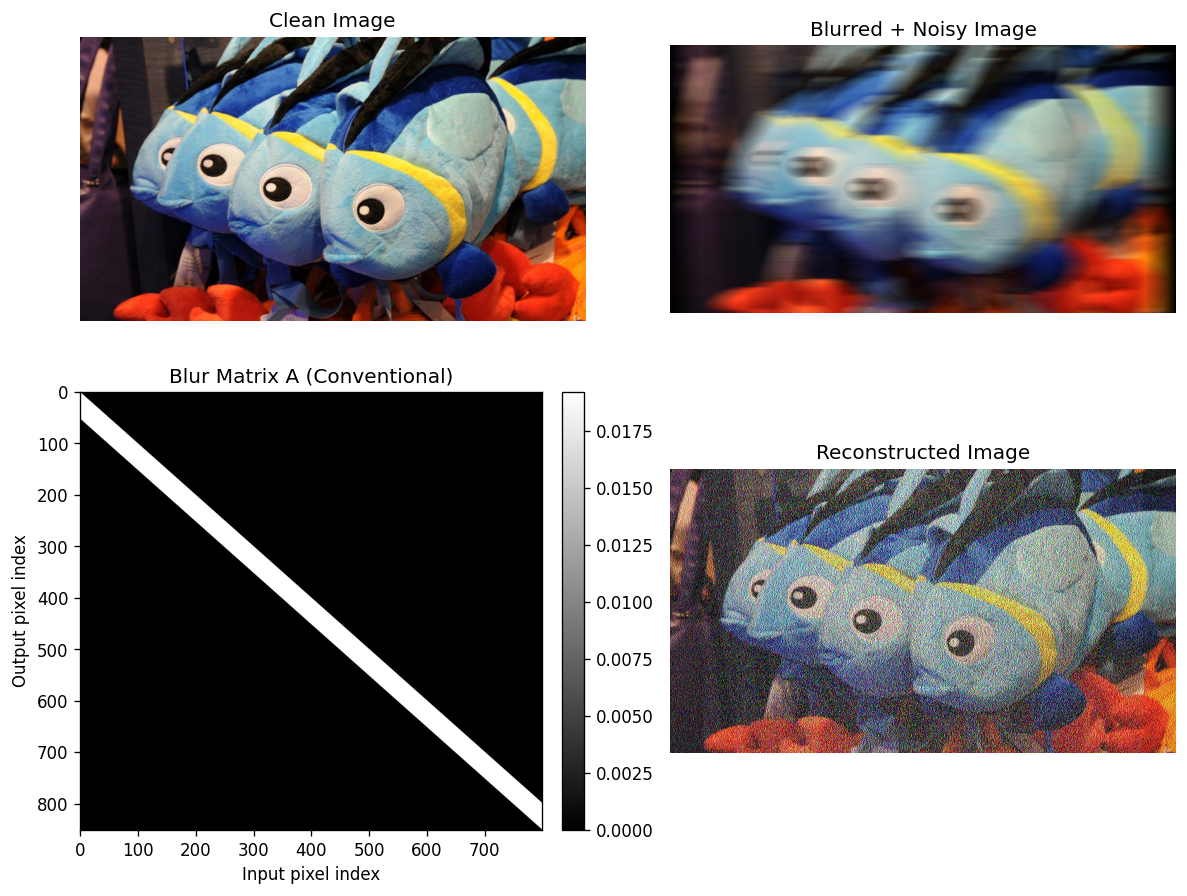

Box blur inversion is ill-conditioned; least squares deblurring amplifies noise and may introduce ringing, especially near sharp edges.
In the example, amplified noise dominates.


In [7]:
# Print shapes
print("Clean image shape =", img_clean.shape)
print("Blurred (conv) + noise shape =", blurred_conv_noisy.shape)
print("Blur matrix A shape =", A_conv.shape)
print("Reconstructed image shape =", rec_conv.shape)

# Plotting in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Clean image (top left)
axs[0, 0].imshow(img_clean.astype(np.uint8))
axs[0, 0].set_title("Clean Image")
axs[0, 0].axis('off')

# Blurred + noisy image (top right)
axs[0, 1].imshow(np.clip(blurred_conv_noisy, 0, 255).astype(np.uint8))
axs[0, 1].set_title("Blurred + Noisy Image")
axs[0, 1].axis('off')

# (b) Display A (visualization)
# Blur matrix A (bottom left)
im = axs[1, 0].imshow(A_conv, cmap='gray', aspect='auto')
axs[1, 0].set_title("Blur Matrix A (Conventional)")
axs[1, 0].set_xlabel("Input pixel index")
axs[1, 0].set_ylabel("Output pixel index")
plt.colorbar(im, ax=axs[1, 0], fraction=0.046, pad=0.04)

# Reconstructed image (bottom right)
axs[1, 1].imshow(np.clip(rec_conv, 0, 255).astype(np.uint8))
axs[1, 1].set_title("Reconstructed Image")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# (d) Observation:  noise amplification are expected.
print("Box blur inversion is ill-conditioned; least squares deblurring amplifies noise and may introduce ringing, especially near sharp edges.")
print("In the example, amplified noise dominates.")